Paul writes:
 - Cosmos to full depth: hsc-1361/20151104/cosmos
 - Cosmos to wide depth with interleaved exposures: hsc-1361/20151104/cosmos[12]
 - Two tracts of wide: hsc-1361/20151104/wide

In [14]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.utils as ds9Utils
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
import os
butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"], "rerun",
    "hsc-1361/20151104/cosmos"))

In [3]:
dataId = dict(tract=0, patch='5,5', filter='HSC-I', sfilter='i')
coadd = butler.get("deepCoadd_calexp", dataId, immediate=True)

In [5]:
frame = 0
if 1:
    ds9.mtv(coadd, title=str(dataId)[1:-1], frame=frame)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll exec it for you


In [6]:
meas = butler.get("deepCoadd_meas", dataId)

print "%d sources, of which %d are sky" % (
    len(meas), np.sum(meas.get('merge.footprint.sky')))

32643 sources, of which 99 are sky


In [7]:
if 1:
    ds9.erase(frame=frame)
    with ds9.Buffering():
        for s in meas:
            ds9.dot('+' if s.get('merge.peak.%s' % dataId["sfilter"]) else 'x',
                    s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=3, 
                    ctype=ds9.RED, frame=frame)
    with ds9.Buffering():
        for s in meas[meas['merge.peak.sky']]:
            ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=12,
                    ctype=ds9.CYAN, frame=frame)
    if False:
        with ds9.Buffering():
            for s in meas[meas['detect.is-primary']]:
                ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=10,
                        ctype=ds9.GREEN, frame=frame)

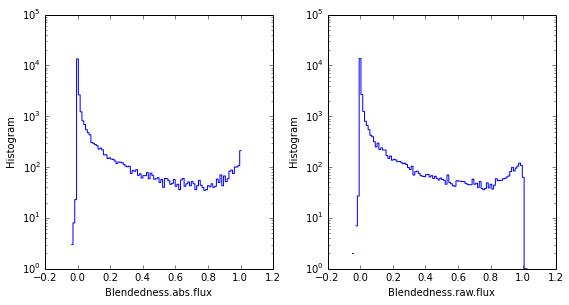

In [16]:
ax = plt.subplot(221)
ax.hist(meas['blendedness.abs.flux'], 100, range=(-0.05, 1.05), histtype='step')
ax.set_yscale('log')
ax.set_xlabel("Blendedness.abs.flux")
ax.set_ylabel("Histogram")

ax = plt.subplot(222)
ax.hist(meas['blendedness.raw.flux'], 100, range=(-0.05, 1.05), histtype='step')
ax.set_yscale('log')
ax.set_xlabel("Blendedness.raw.flux")
ax.set_ylabel("Histogram")
plt.tight_layout()

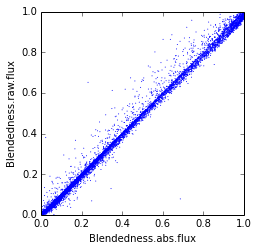

In [22]:
b_abs = meas['blendedness.abs.flux']
b_raw = meas['blendedness.raw.flux']
ax = plt.subplot(221)
ax.scatter(b_abs, b_raw, s=1, lw=0)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Blendedness.abs.flux")
ax.set_ylabel("Blendedness.raw.flux")

In [29]:
# Check what fraction is nan
nan_abs = np.sum(np.isnan(b_abs))*100.0/b_abs.size
nan_raw = np.sum(np.isnan(b_raw))*100.0/b_raw.size

print("Percentage of blendedness.abs.flux nans: %.3f" % nan_abs )
print("Percentage of blendedness.raw.flux nans: %.3f" % nan_raw )

idx_abs = np.logical_not(np.isnan(b_abs))
idx_raw = np.logical_not(np.isnan(b_raw))

print "This should be zero if NANs are shared by blendedness.abs.flux and blendedness.raw.flux : ", np.sum(idx_abs!=idx_raw)
idx = np.logical_not(np.isnan(b_abs))

# Some statistics
fail_abs = np.sum((b_abs[idx]<0.0) | (b_abs[idx]>1.0))*100.0/b_abs[idx].size
fail_raw = np.sum((b_raw[idx]<0.0) | (b_raw[idx]>1.0))*100.0/b_raw[idx].size

print("Percentage of blendedness.abs.flux out of bounds: %.3f" % fail_abs )
print("Percentage of blendedness.raw.flux out of bounds: %.3f" % fail_raw )

Percentage of blendedness.abs.flux nans: 14.582
Percentage of blendedness.raw.flux nans: 14.582
This should be zero if NANs are shared by blendedness.abs.flux and blendedness.raw.flux :  0
Percentage of blendedness.abs.flux out of bounds: 1.119
Percentage of blendedness.raw.flux out of bounds: 1.259


In [46]:
# Check all the keys in meas
flags_noShape=meas['blendedness.flags.noShape']
flags_noCentroid=meas['blendedness.flags.noCentroid']

print("Percentage of flagged objects with noShape : %.3f" % (np.sum(flags_noShape)*100./flags_noShape.size))
print("Percentage of flagged objects with noCentroid : %.3f" % (np.sum(flags_noCentroid)*100./flags_noCentroid.size))

print("Zero if all NANs are flagged as having noShape : %.3f " %(np.sum( np.isnan(b_abs) & (flags_noShape==0) )))

print("Zero if all NANs are flagged as having noCentroid : %.3f " %(np.sum( np.isnan(b_abs) & (flags_noCentroid==0) )))

Percentage of flagged objects with noShape : 14.582
Percentage of flagged objects with noCentroid : 7.864
Zero if all NANs are flagged as having noShape : 0.000 
Zero if all NANs are flagged as having noCentroid : 3520.000 


In [47]:
class Cmap(object):
    """An object to take a matplotlib colourmap name and return a ds9-compliant ctype
    
    E.g.
       cmap = Cmap("rainbow", (0, 1))
       ds9.dot('o', s.getX(), s.getY(), ctype=cmap.ctype(s['blendedness.abs.flux'])
    """
    def __init__(self, cmapName="rainbow", range=(0, 1)):
        self._cmap = plt.get_cmap(cmapName)
        self.N = self._cmap.N
        self._min = range[0]
        self._scale = (self.N - 1)/float(range[1] - range[0])
        
    def ctype(self, value):
        if not np.isfinite(value):
            color = (0.0, 0.0, 0.0)
        else:
            color = self._cmap(int(self._scale*(value - self._min)))
            
        return '#%04x%04x%04x' % (65535*color[0], 65535*color[1], 65535*color[2])

In [50]:
cmap = Cmap("rainbow", (0, 0.25))

ds9.erase()
with ds9.Buffering():
    for s in meas:
        if s['parent'] != 0:
            ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=10, 
                        ctype=cmap.ctype(s['blendedness.abs.flux']), frame=frame)